# Learning Shortest-Distance in Boston Harbor
### With conditional autoencoder

Based on this research (same model, new application):

    Ichter, B., Harrison, J., & Pavone, M. (2018, May). 
    Learning sampling distributions for robot motion planning. 
    In 2018 IEEE International Conference on Robotics and Automation (ICRA) (pp. 7087-7094). IEEE.
 

## Setup

In [1]:
# Import libraries
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import numpy as np
import os
import matplotlib.pyplot as plt

# Import local
from CVAE_Model import CVAE

# Use Cuda if possible
print("Cuda available?  {}".format(torch.cuda.is_available()))
print("Cuda version: {}".format(torch.version.cuda))
try:
    device = torch.device("cuda")
    torch.ones(5).to("cuda")
except:
    print("Cuda failed to work! Using CPU...")
    device = torch.device("cpu")

Cuda available?  True
Cuda version: 10.2


In [2]:
# Options
TRAIN_MODEL = True # Train? or just test existing?
SAVE_MODEL = False  # Should save the model?
MODEL_PATH = "BostonHarbor_example.pt"
printFreq = 25
maxSamples = 400000  # Because all samples may crash

# Hyperparams: training
trainProp = 0.8
batchSize = 256
epochs = 200
learnRate = 1e-3

# Hyperparams: network
hiddenEncoderSize = 712
hiddenDecoder_1_Size = 712
hiddenDecoder_2_Size = 712
latentSize = 3

# Raster
rasterFile = "BostonHarborData/data/full_shrink_2.asc"
occGrid = np.loadtxt(rasterFile, skiprows=6) # First 6 are metadata
occShape = occGrid.shape

In [3]:
#Load data
dataFile = "BostonHarbor_Data.npz"
data = np.load(dataFile)
data = data["data"][:maxSamples,:].astype("float16")

# X : start (row, col)
xData = data[:,0:2]

# C: init (row, col), goal (row, col)
cData = data[:,2:6]

# Normalize coordinates
xData[:, 0] = xData[:, 0] / occShape[0]
xData[:, 1] = xData[:, 1] / occShape[1]
cData[:, 0] = cData[:, 0] / occShape[0]
cData[:, 1] = cData[:, 1] / occShape[1]
cData[:, 2] = cData[:, 2] / occShape[0]
cData[:, 3] = cData[:, 3] / occShape[1]

nEntries = xData.shape[0]

# Split into train, test
nTrain = int(nEntries * trainProp)
xTrain = xData[0:nTrain, :]
cTrain = cData[0:nTrain, :]
xTest  = xData[nTrain:, ]
cTest  = cData[nTrain:, ] 

print("Loaded data:")
print("  File: {}".format(dataFile))
print("  Samples (x) shape: {}".format(xData.shape))
print("  Conditions (c) shape: {}".format(cData.shape))
print("  Training: {},   testing: {}".format(xTrain.shape[0], 
                                             xTest.shape[0]))

Loaded data:
  File: BostonHarbor_Data.npz
  Samples (x) shape: (400000, 2)
  Conditions (c) shape: (400000, 4)
  Training: 320000,   testing: 80000


In [4]:
# Create data loaders
def makeDataLoader(x, c, batchSize, shuffle=False):
    xTensor = torch.Tensor(x)
    cTensor = torch.Tensor(c)
    dataset = TensorDataset(xTensor, cTensor)
    dataLoader  = DataLoader(dataset, batch_size=batchSize, shuffle=shuffle)
    return xTensor, cTensor, dataset, dataLoader
    
xTrainTensor, cTrainTensor, trainDataset, trainDataLoader = \
    makeDataLoader(xTrain, cTrain, batchSize, shuffle=True)

xTestTensor, cTestTensor, testDataset, testDataLoader = \
    makeDataLoader(xTest, cTest, batchSize, shuffle=False)

## Train

In [5]:
# Define loss function
def loss_fn(reconstructed_x, x, mu, logvar):
    # Reconstruction + KL divergence loss 

    def MSE(pred, target):
        
        #return torch.sum((pred - target) ** 2)
        return torch.mean((pred - target) ** 2)
    
    # Reconstruction loss
#     recon_loss = weightedMSE(reconstructed_x, x, weight)
    recon_loss = MSE(reconstructed_x, x)
    
    # KL divergence loss
    KL_loss = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar, 1)
    
    return torch.mean(recon_loss + KL_loss)


# Define batch training
def train(model, optimizer, dataLoader, device="cpu"):
    model.to(device)
    model.train()
    train_loss = 0
    for batch_idx, (X, C) in enumerate(dataLoader):
        X, C = X.to(device), C.to(device)
        q_z, logvar, mu, z = model(X, C)
        optimizer.zero_grad()
        cvae_loss = loss_fn(q_z, X, mu, logvar) 
        cvae_loss.backward()
        optimizer.step()
        train_loss += cvae_loss
    return train_loss / batchSize
    

# Define batch testing
def test(model, dataLoader, device="cpu"):
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (X, C) in enumerate(dataLoader):
            X, C = X.to(device), C.to(device)
            q_z, logvar, mu, z = model(X, C)
            cvae_loss = loss_fn(q_z, X, mu, logvar)
            test_loss += cvae_loss
    return test_loss / batchSize

In [6]:
# Init model
model = CVAE(
    sample_size = xTrain.shape[1],
    condition_size = cTrain.shape[1],
    hidden_encoder_size = hiddenEncoderSize,
    hidden_decoder_1_size = hiddenDecoder_1_Size,
    hidden_decoder_2_size = hiddenDecoder_2_Size,
    latent_size = latentSize,
).to(device)

# Init optimizer
optimizer = optim.Adam(model.parameters(), lr=learnRate)

In [7]:
def printModelOut(model, dataLoader, nPrint=10, device="cpu"):
    X, C = next(iter(trainDataLoader))
    X, C = X.to(device), C.to(device)
    q_z, logvar, mu, z = model(X, C)
    for i in range(nPrint):
        print("({:.6f}, {:.6f})  -->  ({:.6f}, {:.6f})".format(
            X[i,0], X[i,1], q_z[i,0], q_z[i,1]))

In [8]:
if TRAIN_MODEL:
    # Train
    for epoch in range(epochs):
        train_loss = train(model, optimizer, trainDataLoader, device=device)
        if epoch % printFreq == 0:
            test_loss = test(model, testDataLoader, device=device)
            print("Epoch: {},  Train loss: {:.6f},   Test lost: {:.6f}".format(epoch, train_loss, test_loss))
            printModelOut(model, trainDataLoader, device=device)
            print("")
    if SAVE_MODEL:
        torch.save(model, MODEL_PATH)
else:
    # Load model
    model = torch.load(MODEL_PATH)

Epoch: 0,  Train loss: 0.022930,   Test lost: 0.012202
(0.766602, 0.449951)  -->  (0.606771, 0.377217)
(0.555664, 0.509766)  -->  (0.465468, 0.415958)
(0.255615, 0.469971)  -->  (0.228904, 0.389289)
(0.366699, 0.540039)  -->  (0.301753, 0.473336)
(0.455566, 0.350098)  -->  (0.401882, 0.318208)
(0.277832, 0.270020)  -->  (0.252980, 0.287171)
(0.799805, 0.439941)  -->  (0.653271, 0.347711)
(0.444336, 0.340088)  -->  (0.366535, 0.302840)
(0.655762, 0.549805)  -->  (0.524467, 0.463589)
(0.477783, 0.340088)  -->  (0.393734, 0.306372)

Epoch: 25,  Train loss: 0.006931,   Test lost: 0.003674
(0.633301, 0.350098)  -->  (0.615256, 0.357536)
(0.288818, 0.449951)  -->  (0.267633, 0.449328)
(0.622070, 0.560059)  -->  (0.541356, 0.498135)
(0.411133, 0.360107)  -->  (0.408154, 0.352244)
(0.522461, 0.720215)  -->  (0.494182, 0.696867)
(0.211060, 0.600098)  -->  (0.198337, 0.565895)
(0.477783, 0.239990)  -->  (0.493408, 0.240374)
(0.544434, 0.540039)  -->  (0.493049, 0.585701)
(0.611328, 0.609863)  --

KeyboardInterrupt: 

## Test

In [9]:
# Test
model.to(device)
test_loss = test(model, testDataLoader, device=device)
print("Mean loss: {:.6f}".format(test_loss))

Mean loss: 0.013963


In [10]:
model.to(device)
print("Train samples:")
printModelOut(model, trainDataLoader, device=device)
print("\n")
print("Test samples:")
printModelOut(model, testDataLoader, device=device)

Train samples:
(0.422119, 0.260010)  -->  (0.390682, 0.228867)
(0.344482, 0.580078)  -->  (0.305931, 0.600823)
(0.466553, 0.370117)  -->  (0.426168, 0.364734)
(0.288818, 0.509766)  -->  (0.287077, 0.503015)
(0.211060, 0.229980)  -->  (0.222488, 0.241512)
(0.789062, 0.700195)  -->  (0.564218, 0.603621)
(0.544434, 0.419922)  -->  (0.382179, 0.393302)
(0.866699, 0.459961)  -->  (0.616708, 0.465426)
(0.899902, 0.439941)  -->  (0.628108, 0.445466)
(0.744629, 0.489990)  -->  (0.500868, 0.526777)


Test samples:
(0.133301, 0.609863)  -->  (0.126578, 0.593500)
(0.666504, 0.540039)  -->  (0.541689, 0.620721)
(0.744629, 0.529785)  -->  (0.519879, 0.537555)
(0.333252, 0.680176)  -->  (0.326592, 0.673471)
(0.866699, 0.509766)  -->  (0.598822, 0.411603)
(0.199951, 0.620117)  -->  (0.170382, 0.596092)
(0.222168, 0.219971)  -->  (0.250515, 0.234818)
(0.422119, 0.399902)  -->  (0.335778, 0.404645)
(0.533203, 0.370117)  -->  (0.430934, 0.443035)
(0.377686, 0.600098)  -->  (0.339837, 0.579575)


In [11]:
def printSample(sample, showGrid=False):
    print("Sample x: {}".format(sample["x"]))
    print("    init: {}".format(sample["init"]))
    print("    goal: {}".format(sample["goal"]))
    if showGrid:
        print(" Occupancy grid:")
        print(sample["grid"]) 

def decompose(sample, occdims=(90, 100), verbose=False):
    sample_x, C = sample
    sample_x, C = np.array(sample_x), np.array(C)
    dims = sample_x.shape[0]
    sample_init = C[0:dims]
    sample_goal = C[dims:dims*2]
    occgrid = C[dims*2:]
#     occgrid = occgrid.reshape(occdims)
    return {
        "x"    : sample_x,
        "init" : sample_init, 
        "goal" : sample_goal,
        "grid" : occgrid,
    }

Sample x: [0.6557617  0.38989258]
    init: [0.73339844 0.7998047 ]
    goal: [0.73339844 0.25      ]
Sample x: [0.6557617  0.41992188]
    init: [0.7446289  0.48999023]
    goal: [0.09997559 0.10998535]
Sample x: [0.5776367  0.45996094]
    init: [0.4111328 0.1899414]
    goal: [0.7001953 0.75     ]
Sample x: [0.51123047 0.45996094]
    init: [0.8334961  0.58984375]
    goal: [0.25561523 0.39990234]
Sample x: [0.4777832 0.4099121]
    init: [0.5776367  0.33007812]
    goal: [0.31103516 0.5600586 ]
Sample x: [0.39990234 0.6098633 ]
    init: [0.48876953 0.6098633 ]
    goal: [0.14440918 0.6401367 ]
Sample x: [0.51123047 0.44995117]
    init: [0.31103516 0.09002686]
    goal: [0.72216797 0.72998047]
Sample x: [0.39990234 0.3400879 ]
    init: [0.09997559 0.3701172 ]
    goal: [0.36669922 0.18005371]
Sample x: [0.38891602 0.5097656 ]
    init: [0.4111328  0.18005371]
    goal: [0.30004883 0.70996094]
Sample x: [0.64453125 0.4399414 ]
    init: [0.7890625  0.26000977]
    goal: [0.4665527

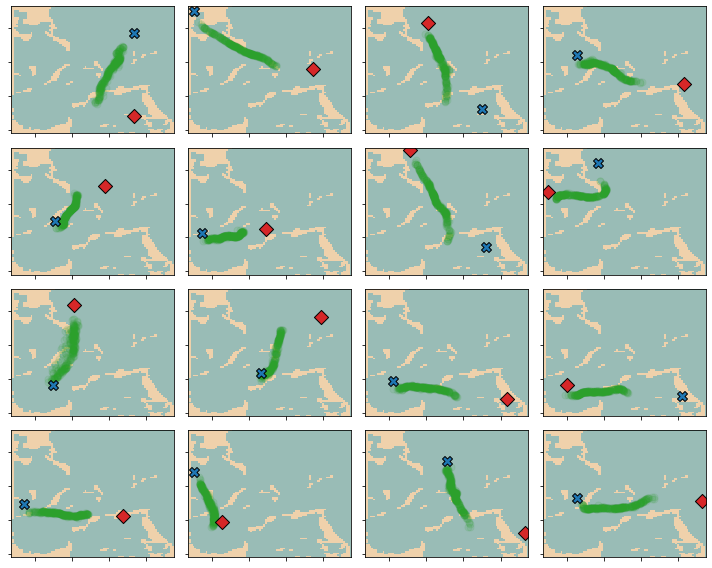

In [17]:
# Get sample condition
dataset = trainDataset
plt.rc('text', usetex=False)
sample_idxs = np.array([
    [29, 590, 250, 4652], 
    [3290, 1155, 1110, 11440], 
    [11640, 4234, 9348, 123],
    [2545, 25515, 818, 2112],
])

# Colors
from matplotlib.colors import LinearSegmentedColormap
sea = (153.0/255.0, 188.0/255.0, 182.0/255.0)
land = (239.0/255.0, 209.0/255.0, 171.0/255.0)
cm_landsea = LinearSegmentedColormap.from_list(
     "landsea", [sea, land], N = 2)

fig, axs = plt.subplots(sample_idxs.shape[0], 
                        sample_idxs.shape[1],
                       figsize=(10, 8))

for i in range(sample_idxs.shape[0]):
    for j in range(sample_idxs.shape[1]):
        sample_idx = sample_idxs[i, j]
        sample_X, sample_C = dataset[sample_idx]
        sample = decompose(dataset[sample_idx], occdims=occShape, verbose=True)
        printSample(sample)

        # Convert to length-1 batches for model compatability
        sample_C = torch.unsqueeze(sample_C, 0)

        # Sample latent space
        z_dim = model.latent_size
        z = torch.Tensor(np.random.randn(batchSize, z_dim))
        sample_C = torch.Tensor(np.tile(sample_C, (batchSize, 1)))
        
        model.to("cpu")
        model.eval()
        with torch.no_grad():
            res = np.array(model.decoder(z, sample_C))

        # Plot
        axs[i][j].scatter((res[:,0] * 100), (res[:,1] * 90 + 5), color="tab:green", s=50, alpha=0.1);
        axs[i][j].scatter((sample["init"][0] * 100), (sample["init"][1] * 90), 
                    s=100, color="tab:red", edgecolors="black", marker="D");
        axs[i][j].scatter((sample["goal"][0] * 100), (sample["goal"][1] * 90),
                    s=100, color="tab:blue", edgecolors="black", marker="X");
        axs[i][j].set_facecolor(color=sea)
        axs[i][j].imshow(occGrid, origin='lower', cmap=cm_landsea, interpolation='nearest', aspect='auto');
        axs[i][j].yaxis.set_ticklabels([])
        axs[i][j].xaxis.set_ticklabels([])
        axs[i][j].set_xlim(7,95)
        axs[i][j].set_ylim(7,82)

        axs[i][j].invert_yaxis();
        plt.tight_layout()
